## IST557 Midterm ##
author: Andrew Sugarman

#### References:
1. https://scikit-learn.org/1.5/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
2. https://www.cs.toronto.edu/~duvenaud/cookbook/ 
3. https://modelassist.epixanalytics.com/space/EA/26575606/A+stock+or+share+price,+or+interest+rate,+modeled+over+time
4. https://scikit-learn.org/1.5/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
5. https://faridjb.github.io/Time-Series-Exploration/chapters/chapter_05.html
6. https://hannibunny.github.io/mlbook/machinelearning/gp.html
7. https://docs.scipy.org/doc/scipy/reference/optimize.html
8. 


https://www.youtube.com/watch?v=UBDgSHPxVME


In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 
df = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
df['log_stock_price'] = np.log(df['stock_price'])
df['raw_change'] = df['stock_price'].diff()
df['log_change'] = df['log_stock_price'].diff()
df.head()

,date,stock_price,log_stock_price,raw_change,log_change
0,2011-01-02,28.072510,3.334791,NaN,NaN
1,2011-01-09,27.341080,3.308390,-0.731430,-0.026400
2,2011-01-16,28.636974,3.354699,1.295894,0.046308
3,2011-01-23,29.137842,3.372038,0.500868,0.017339
4,2011-01-30,29.233253,3.375307,0.095411,0.003269


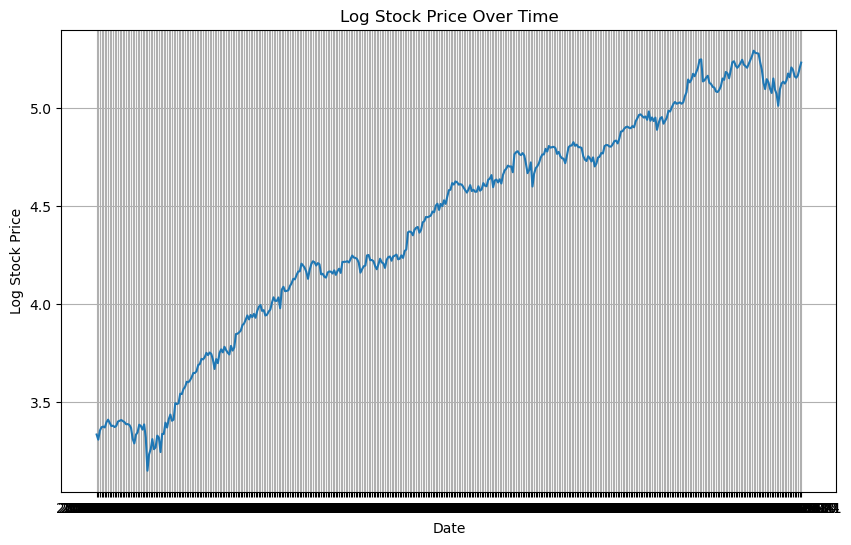

In [51]:
# plotting options
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['log_stock_price'])
plt.title('Log Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.grid(True)
plt.show()

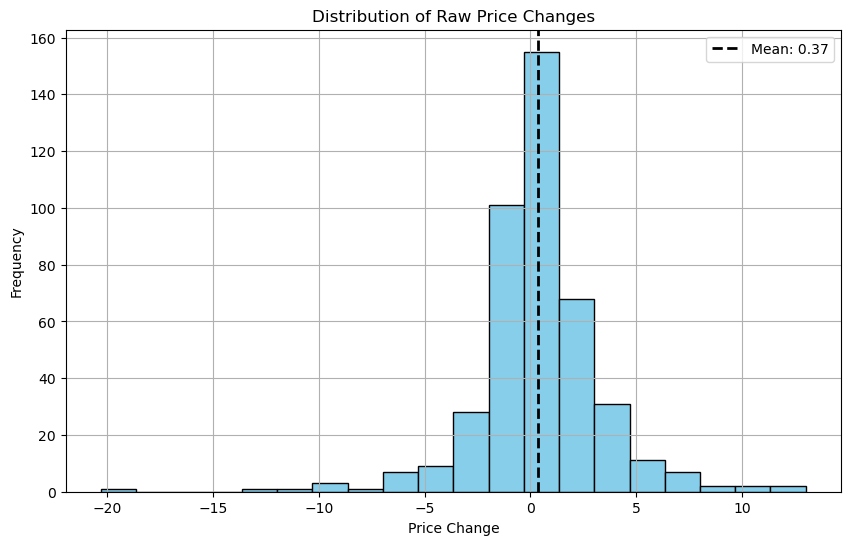

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(df['raw_change'].dropna(), bins=20, edgecolor='black', color='skyblue')
mean_change = df['raw_change'].mean()
plt.axvline(mean_change, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_change:.2f}')
plt.title('Distribution of Raw Price Changes')
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

datetime64[ns]


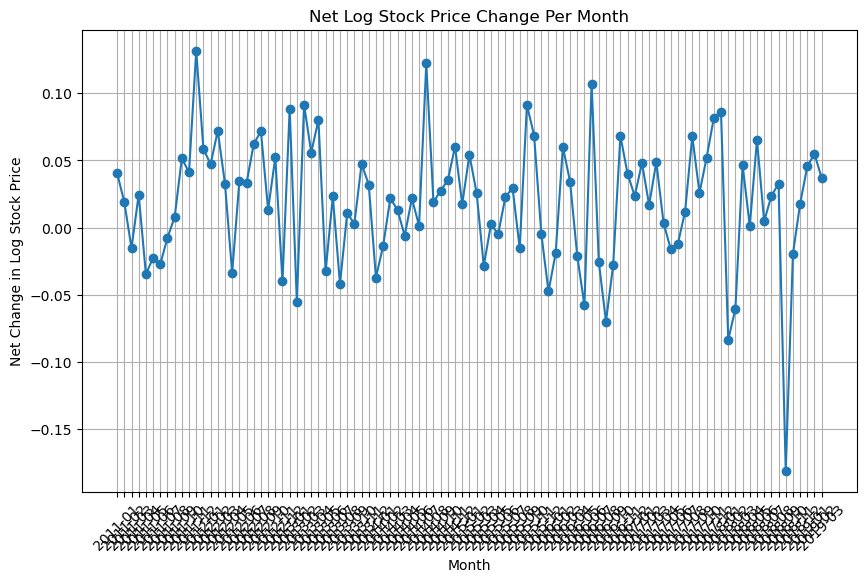

In [53]:
# plot average stock price for each month
# calculate net change in stock price per month 
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)
df['year_month'] = df['date'].dt.to_period('M')
month_means = df.groupby('year_month')['stock_price'].mean().reset_index()
month_changes = df.groupby('year_month')['log_change'].sum().reset_index()
#
plt.figure(figsize=(10, 6))
plt.plot(month_changes['year_month'].astype(str), month_changes['log_change'], marker='o')
plt.title('Net Log Stock Price Change Per Month')
plt.xlabel('Month')
plt.ylabel('Net Change in Log Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
 # plt.show()

### Problem 1a

- By plotting the distribution of change in log stock price we are able to look at how stable the price typically is from day to day, which may become important in feature selection and model parameter tuning. It is of interest to my model whether there are many drastic changes or mostly gradual changes accompanied by the occasional spike or dip. According to the histogram and corroborated by the line plot, it appears that changes in the log stock price are gradual and linear, but become more volatile as time increases. 
- The mean change in raw stock price (between sampled points, which are not every day but every week) is 0.37, indicating that stock price on average increases (since the mean value is positive) and does so at a slow rate (<1)

In summary, the data has an upward trend that generally follows a linear pattern with mixed random variability in some areas. The end of the time series appears to be more variable than the majority of the curve. These observations are informative as we move on to fit a gaussian process regression model, given that they may affect our choice in Kernel function. 

In [54]:
import pandas as pd
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# load data 
df = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
# represent target (stock price) with log transformation for ease-of-use and plotting
df['log_stock_price'] = np.log(df['stock_price'])
# separate from raw differences to keep track of trends in the data
df['raw_change'] = df['stock_price'].diff()
df['log_change'] = df['log_stock_price'].diff()

# calculate net change in stock price per month 
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)
df['year_month'] = df['date'].dt.to_period('M')
month_means = df.groupby('year_month')['stock_price'].mean().reset_index()
month_changes = df.groupby('year_month')['log_change'].sum().reset_index()

# convert datetime column to continuous so that it can be worked with more easily, as done in the volcano sklearn example
df['date'] = pd.to_datetime(df['date'])
reference_date = df['date'].min()
df['days_since_start'] = (df['date'] - reference_date).dt.days

## CHUNK DATA FRAME BEFORE CROSS VALIDATION STEP - I WANT A HOLDOUT SET ##
from sklearn.model_selection import train_test_split

# Split -- for later use if we need to further partition for cross val! remember to postprocess this into numerical datetime format
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
## train_df.head()

# define data ## USING WHOLE TRAINING DATA FOR NOW
x = df['days_since_start']
y = df['log_stock_price']

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



datetime64[ns]


### First pass at fitting a Gaussian Process to the training data
- After reading the volcano example from lecture and scikit learn, I chose an RBF kernel with a large length scale to model the long term gradual growth of this stock price data. Recall that an increased length scale indicates that there is greater correlation between neighboring function values
- After reading the Kernel Cookbook, I chose to combine this kernel with an added term to represent random noise (which is noticeable across regions of this dataset) by including a rational quadratic in my kernel
- it is difficult to tell whether the data is formally periodic or noisy, but I will try fitting my model with and without the inclusion of a periodic kernel

Given the hint in problem 1b, we know that cross-validation has to be done differently than just chunking up the training data into random folds. Since each observation depends on the previous, I will use the time series split function in Sklearn to examine the recommended 5 folds. Thus, the model will be sequentially trained on k folds where the k+1th fold is used as the testing set. 

In [55]:
from sklearn.model_selection import TimeSeriesSplit as tss 
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ExpSineSquared, RationalQuadratic
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor

## CHOOSE YOUR KERNEL
# use an RBF kernel with fat length scale 
length = 50
k1 =  50.0**2 * RBF(length)
# use a rational quadratic kernel to model local noise
k2 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# use a periodic
k3 = (
    5.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
k4 = noise_kernel = 0.1**2 * RBF(length_scale=5) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
# define mixed kernel
kernel = ( k1 + k2 + k3 + k4)

# define input data:
df1 = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
df1['log_stock_price'] = np.log(df['stock_price'])
df1['raw_change'] = df['stock_price'].diff()
df1['log_change'] = df['log_stock_price'].diff()
#
df1['date'] = pd.to_datetime(df1['date'])
reference_date = df1['date'].min()
df1['days_since_start'] = (df1['date'] - reference_date).dt.days
#
x = df1['days_since_start'].values.reshape(-1, 1)
y = df1['log_stock_price']

# define lists to keep track of params during cross val 
params = []
lml = []
mse = []

splitcv = tss(n_splits=10)
for train_index, test_index in splitcv.split(x):
    # define training and testing input vars for each iteration of the loop 
    # ie indices defined for a given fold from 1-5 
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_mean = np.mean(y_train)
    # define and train gpmodel for each iter
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    gaussian_process.fit(x_train, y_train - y_mean)

    # extract param values
    kernel_params = gaussian_process.kernel_
    params.append(kernel_params)
    # make predictions
    y_pred, y_std = gaussian_process.predict(x_test, return_std=True)
    y_pred += y_mean
    #
    params.append(gaussian_process.kernel_)
    mse.append(mean_squared_error(y_test, y_pred))
    lml.append(gaussian_process.log_marginal_likelihood_value_)

## identify the params with highest lml
min_mse_idx = np.argmin(mse)
max_lml_idx = np.argmax(lml)

# choose kernel by best lml
kernel = params[max_lml_idx]


c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\g7712_razer2\mini

In [56]:
# choose kernel by best lml
print(params[max_lml_idx])
gp = GaussianProcessRegressor(kernel=params[max_lml_idx], n_restarts_optimizer=9, normalize_y=False)
y_mean = np.mean(y)

# fit model
gp.fit(x, y - y_mean)

0.00316**2 * RBF(length_scale=9.25e+04) + 0.0261**2 * RationalQuadratic(alpha=2.52, length_scale=8.1) + 0.529**2 * RBF(length_scale=878) * ExpSineSquared(length_scale=1, periodicity=1) + 0.092**2 * RBF(length_scale=96.6) + WhiteKernel(noise_level=0.000231)


c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=0.00316**2 * RBF(length_scale=9.25e+04) + 0.0261**2 * RationalQuadratic(alpha=2.52, length_scale=8.1) + 0.529**2 * RBF(length_scale=878) * ExpSineSquared(length_scale=1, periodicity=1) + 0.092**2 * RBF(length_scale=96.6) + WhiteKernel(noise_level=0.000231),
                         n_restarts_optimizer=9)

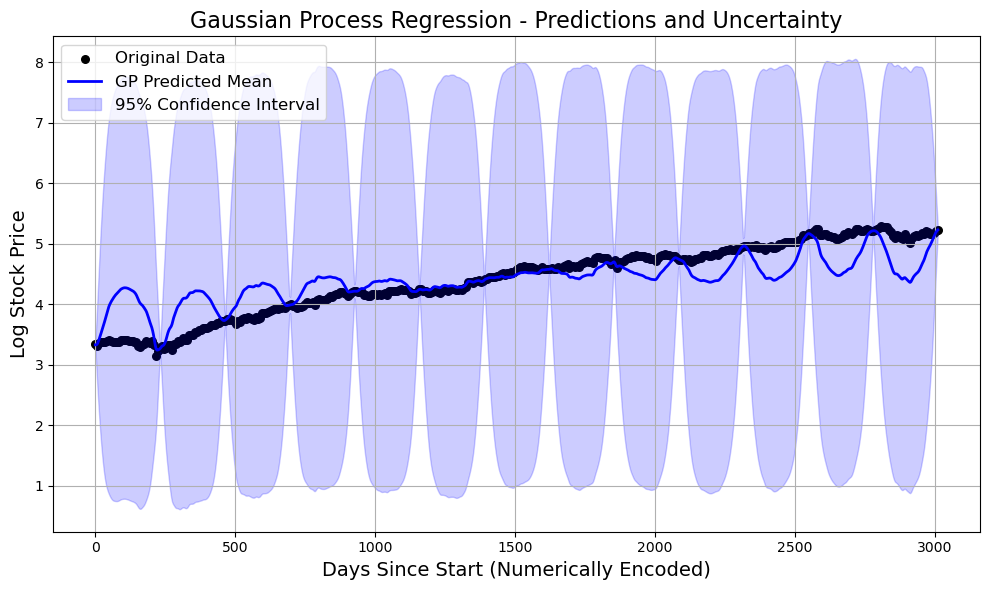

In [57]:
### Predict and plot ###
# Generate predictions on the full range of x (including a smooth range for the plot)
x_smooth = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)  # Create finely spaced x values for a smooth curve
y_pred, y_std = gp.predict(x_smooth, return_std=True)

# Add the mean back to the predictions to get the correct scale
y_pred += y_mean

# Plotting
plt.figure(figsize=(10, 6))

# Plot the original data points
plt.scatter(x, y, color='black', s=30, label='Original Data')

# Plot the GP predicted mean
plt.plot(x_smooth, y_pred, color='blue', lw=2, label='GP Predicted Mean')

# Plot confidence intervals (mean ± 2 * standard deviation for 95% confidence interval)
plt.fill_between(
    x_smooth.ravel(),
    y_pred.ravel() - 2 * y_std,
    y_pred.ravel() + 2 * y_std,
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Customize the plot for aesthetics
plt.xlabel('Days Since Start (Numerically Encoded)', fontsize=14)
plt.ylabel('Log Stock Price', fontsize=14)
plt.title('Gaussian Process Regression - Predictions and Uncertainty', fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

After attempting to include a periodic kernel, we see that the model struggles. Simplifying to an RBF and white noise additive kernel seems to help. 


In [58]:
####### NO PERIODIC:
from sklearn.model_selection import TimeSeriesSplit as tss 
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ExpSineSquared, RationalQuadratic
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor

## CHOOSE YOUR KERNEL
# use an RBF kernel with fat length scale 
length = 50
k1 =  50.0**2 * RBF(length)
# use a rational quadratic kernel to model local noise
k2 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# use a periodic
k3 = (
    5.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
k4 = noise_kernel = 0.1**2 * RBF(length_scale=5) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
# define mixed kernel
## this is good but probably way too overfit
# kernel = ( k1 + k2 + k4)
# kernel = ( k1 + k4) # the white kernel from example was not good
kernel = ( k1 + WhiteKernel())
# define input data:
df1 = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
df1['log_stock_price'] = np.log(df['stock_price'])
df1['raw_change'] = df['stock_price'].diff()
df1['log_change'] = df['log_stock_price'].diff()
#
df1['date'] = pd.to_datetime(df1['date'])
reference_date = df1['date'].min()
df1['days_since_start'] = (df1['date'] - reference_date).dt.days
#
x = df1['days_since_start'].values.reshape(-1, 1)
y = df1['log_stock_price']

# define lists to keep track of params during cross val 
params = []
lml = []
mse = []

splitcv = tss(n_splits=10)
for train_index, test_index in splitcv.split(x):
    # define training and testing input vars for each iteration of the loop 
    # ie indices defined for a given fold from 1-5 
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_mean = np.mean(y_train)
    # define and train gpmodel for each iter
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    gaussian_process.fit(x_train, y_train - y_mean)

    # extract param values
    kernel_params = gaussian_process.kernel_
    params.append(kernel_params)
    # make predictions
    y_pred, y_std = gaussian_process.predict(x_test, return_std=True)
    y_pred += y_mean
    #
    params.append(gaussian_process.kernel_)
    mse.append(mean_squared_error(y_test, y_pred))
    lml.append(gaussian_process.log_marginal_likelihood_value_)

## identify the params with highest lml
min_mse_idx = np.argmin(mse)
max_lml_idx = np.argmax(lml)

# choose kernel by best lml
kernel = params[max_lml_idx]

In [59]:
# choose kernel by best lml
print(params[max_lml_idx])
gp = GaussianProcessRegressor(kernel=params[max_lml_idx], n_restarts_optimizer=9, normalize_y=False)
y_mean = np.mean(y)

# fit model
gp.fit(x, y - y_mean)

0.321**2 * RBF(length_scale=129) + WhiteKernel(noise_level=0.000781)


GaussianProcessRegressor(kernel=0.321**2 * RBF(length_scale=129) + WhiteKernel(noise_level=0.000781),
                         n_restarts_optimizer=9)

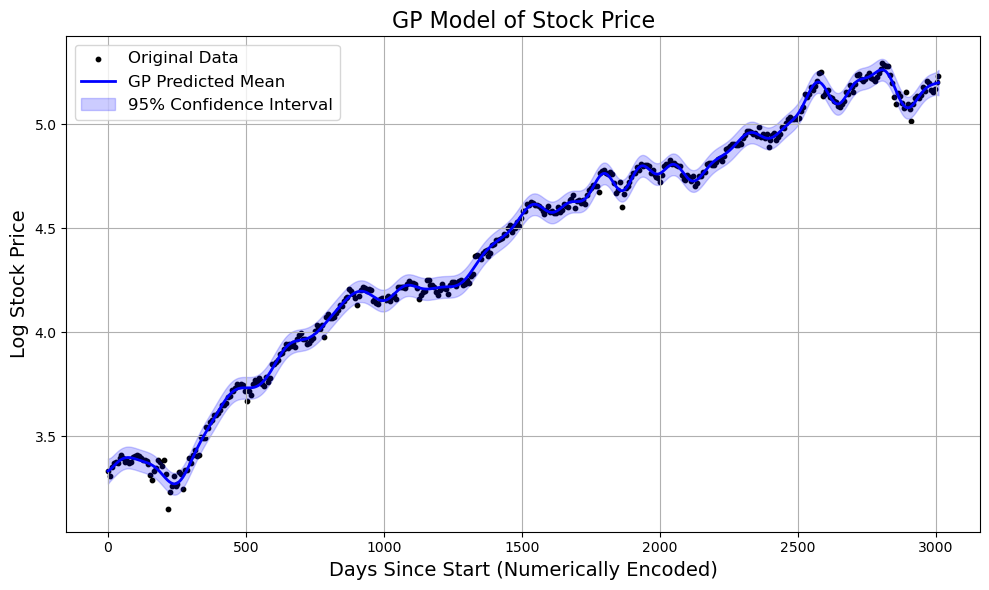

In [60]:
### Predict and plot ###
# Generate predictions on the full range of x (including a smooth range for the plot)
x_smooth = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)  # Create finely spaced x values for a smooth curve
y_pred, y_std = gp.predict(x_smooth, return_std=True)

# Add the mean back to the predictions to get the correct scale
y_pred += y_mean

# plotting
plt.figure(figsize=(10, 6))

# Plot the original data points
plt.scatter(x, y, color='black', s=10, label='Original Data')
plt.plot(x_smooth, y_pred, color='blue', lw=2, label='GP Predicted Mean')

# Plot confidence intervals
plt.fill_between(
    x_smooth.ravel(),
    y_pred.ravel() - 2 * y_std,
    y_pred.ravel() + 2 * y_std,
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)

plt.xlabel('Days Since Start (Numerically Encoded)', fontsize=14)
plt.ylabel('Log Stock Price', fontsize=14)
plt.title('GP Model of Stock Price', fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

This model looks better with the default white noise kernel, but I fear it still might be too heavily overfit. I will try a custom mean fitting the trend of y.
maybe i will use a linear kernel. I have been trying to make a periodic kernel or at least a combined periodic kernel work, but it does not want to work.

### 

In [116]:
### ... ### ... ###
from sklearn.model_selection import TimeSeriesSplit as tss 
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ExpSineSquared, RationalQuadratic
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor

# define mixed kernel
## this is good but probably way too overfit
# kernel = ( k1 + k2 + k4)
# kernel = ( k1 + k4) # the white kernel from example was not good
kernel = ( RBF() + DotProduct() + WhiteKernel() + RationalQuadratic())
kernel = ( DotProduct() + WhiteKernel(noise_level=5) + RationalQuadratic())
# 15 was a great length scale from guess and check
kernel = ( RBF(length_scale=15.0, length_scale_bounds=(25, 1000.0)) + DotProduct() + WhiteKernel() + RationalQuadratic())

## this perfectly overfits the data
kernel = RBF(length_scale=15.0, length_scale_bounds=(25, 1000.0))

# This again is not bad
kernel = RBF(length_scale=15.0, length_scale_bounds=(0.1, 1000.0)) + WhiteKernel(noise_level=50)

# periodic still sucks
kernel = (DotProduct() * ExpSineSquared()) + WhiteKernel()

# 
kernel = RBF() + WhiteKernel(noise_level=1.0, noise_level_bounds=(.0001, 50.0))
# This again is not bad
kernel = RBF(length_scale=15.0, length_scale_bounds=(0.1, 1000.0)) + WhiteKernel(noise_level=50)

# define input data:
df1 = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
df1['log_stock_price'] = np.log(df['stock_price'])
df1['raw_change'] = df['stock_price'].diff()
df1['log_change'] = df['log_stock_price'].diff()
#
df1['date'] = pd.to_datetime(df1['date'])
reference_date = df1['date'].min()
df1['days_since_start'] = (df1['date'] - reference_date).dt.days
#
x = df1['days_since_start'].values.reshape(-1, 1)
y = df1['log_stock_price']

# define lists to keep track of params during cross val 
params = []
lml = []
mse = []

splitcv = tss(n_splits=10)
for train_index, test_index in splitcv.split(x):
    # define training and testing input vars for each iteration of the loop 
    # ie indices defined for a given fold from 1-5 
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_mean = np.mean(y_train)
    # define and train gpmodel for each iter
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    gaussian_process.fit(x_train, y_train - y_mean)

    # extract param values
    kernel_params = gaussian_process.kernel_
    params.append(kernel_params)
    # make predictions
    y_pred, y_std = gaussian_process.predict(x_test, return_std=True)
    y_pred += y_mean
    #
    params.append(gaussian_process.kernel_)
    mse.append(mean_squared_error(y_test, y_pred))
    lml.append(gaussian_process.log_marginal_likelihood_value_)

## identify the params with highest lml
min_mse_idx = np.argmin(mse)
max_lml_idx = np.argmax(lml)

# choose kernel by best lml
kernel = params[max_lml_idx]

c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\g7712_razer2\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [117]:
# choose kernel by best lml
print(params[max_lml_idx])
gp = GaussianProcessRegressor(kernel=params[max_lml_idx], n_restarts_optimizer=9, normalize_y=False)
y_mean = np.mean(y)

# fit model
gp.fit(x, y - y_mean)

RBF(length_scale=584) + WhiteKernel(noise_level=0.000259) + 0.237**2 * RationalQuadratic(alpha=0.00872, length_scale=75.2)


GaussianProcessRegressor(kernel=RBF(length_scale=584) + WhiteKernel(noise_level=0.000259) + 0.237**2 * RationalQuadratic(alpha=0.00872, length_scale=75.2),
                         n_restarts_optimizer=9)

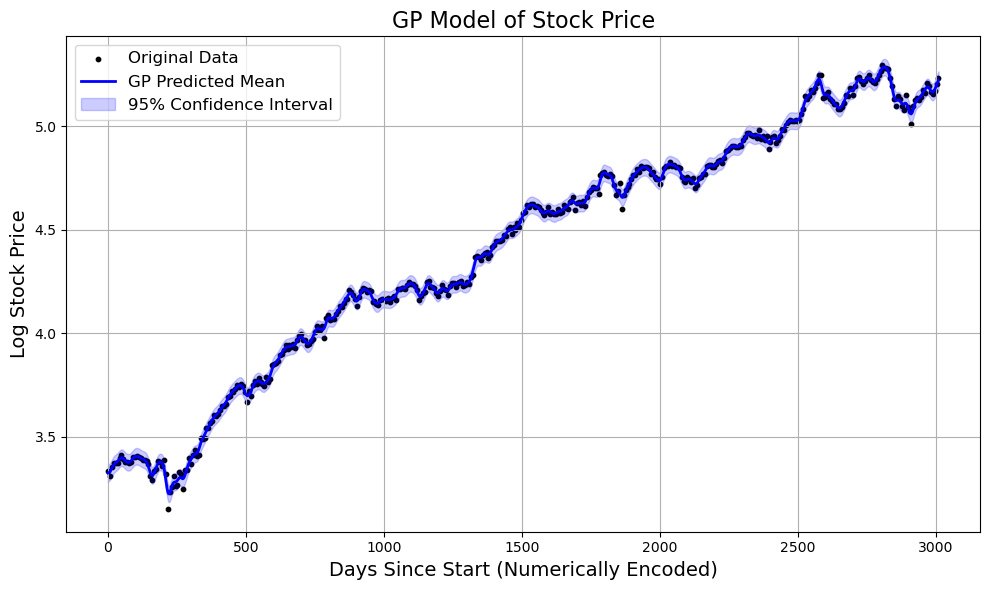

In [118]:
### Predict and plot ###
# Generate predictions on the full range of x (including a smooth range for the plot)
x_smooth = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)  # Create finely spaced x values for a smooth curve
y_pred, y_std = gp.predict(x_smooth, return_std=True)

# Add the mean back to the predictions to get the correct scale
y_pred += y_mean

# plotting
plt.figure(figsize=(10, 6))

# Plot the original data points
plt.scatter(x, y, color='black', s=10, label='Original Data')
plt.plot(x_smooth, y_pred, color='blue', lw=2, label='GP Predicted Mean')

# Plot confidence intervals
plt.fill_between(
    x_smooth.ravel(),
    y_pred.ravel() - 2 * y_std,
    y_pred.ravel() + 2 * y_std,
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)

plt.xlabel('Days Since Start (Numerically Encoded)', fontsize=14)
plt.ylabel('Log Stock Price', fontsize=14)
plt.title('GP Model of Stock Price', fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Cross validation is relatively effective but the model appears to be overfitting, indicating we need a kernel adjustment
- Food for thought - partition the data before cross validation?
- extend out the dataset drastically and plot what it looks like out-of-distribution (training set)